# CityHack 2022 Dataset Generation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf

In [2]:
path_1 = os.getcwd() + '/dataset/LSME-processed-train-01.csv'
path_2 = os.getcwd() + '/dataset/LSME-processed-test-01.csv'

In [3]:
training_set = pd.read_csv(path_1,sep=',')
#test_set = pd.read_csv(path_2,sep=',')

In [4]:
training_set = training_set[['X1','X2','X3','X4','Y','doy','time','hour','dow','week','month','day']]
# test_set = test_set[['X1m','X2m','X3m','X4m','doy','time','hour','dow','week','month','day']]


In [5]:
y = training_set['Y']
X = training_set.drop(columns=['Y'])

In [6]:
y_true = y[len(y) - int(len(y)*0.2):]
y = y[:len(y) - int(len(y)*0.2)]

X_test = X[len(X) - int(len(X)*0.2):]
X = X[:len(X) - int(len(X)*0.2)]


In [7]:
print(len(y_true),len(X_test))

8386 8386


In [8]:
X_train, X_val, y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Code for HyperParameter Tuning and running the model

### Custom Regression Model

In [9]:
from tensorflow.python.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from tensorflow.python.keras.layers import Dropout, Dense, GlobalAveragePooling2D, InputLayer
# from tensorflow.keras.optimizers import Adam
import h5py
import keras_tuner as kt
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# from tensorflow.keras.applications import ResNet50

def DNN_Regressor():
    model = Sequential()
    
    model.add(InputLayer(input_shape=(11,)))
    model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))
    model.add(Dense(32, kernel_initializer='normal',activation='relu'))

    model.add(Dense(1,kernel_initializer='normal',activation='linear'))

    return model

AlreadyExistsError: Another metric with the same name already exists.

HyperParameter Optimisation

In [10]:
def model_builder(hp):
    model = DNN_Regressor()
    model.summary()

    hp_learning = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    
    model.compile(
        optimizer=Adam(learning_rate=hp_learning),
        loss = keras.losses.MeanAbsoluteError(),
        metrics=['mean_absolute_error']
    )

    return model

In [11]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective = kt.Objective("val_mean_absolute_error", direction="min"),
    max_trials = 25,
    directory = 'mydir',
    project_name = 'keras-tuner'
)

NameError: name 'kt' is not defined

In [12]:
tuner.search(X_train, y_train, epochs = 100, validation_data = (X_val, Y_val))

NameError: name 'tuner' is not defined

In [2]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(best_hps)

NameError: name 'tuner' is not defined

In [253]:
model = tuner.hypermodel.build(best_hps)
hist = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data = (X_val, Y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1536      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 77,825
Trainable params: 77,825
Non-trainable params: 0
__________________________________________________

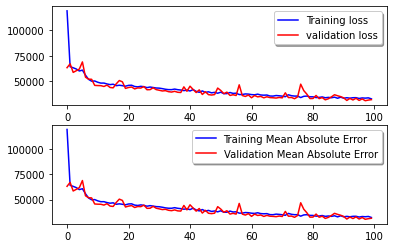

In [254]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['mean_absolute_error'], color='b', label="Training Mean Absolute Error")
ax[1].plot(hist.history['val_mean_absolute_error'], color='r',label="Validation Mean Absolute Error")
legend = ax[1].legend(loc='best', shadow=True)

In [255]:
model.save('models/model_NNR.hdf5')
keras.utils.vis_utils.plot_model(model, to_file='models/model_NNR.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
model =tf.keras.models.load_model('models/model_NNR.hdf5')

AlreadyExistsError: Another metric with the same name already exists.

In [3]:

print("The MAE Coefficient is: {}".format(mean_absolute_error(y_true,model.predict(X_test))))


NameError: name 'mean_absolute_error' is not defined

### SVR

In [256]:
param_grid = [
    {
        'name':'krr-rbf',
        'clf':KernelRidge(kernel='rbf'),
        'params':{
            'alpha':np.logspace(-10,10,25),
            'degree':[1,2,3,4,5,6,7,8,9]
        }    
    },
    {
        'name':'krr-poly',
        'clf':KernelRidge(kernel='poly'),
        'params':{
            'alpha': np.logspace(-10,10,25), 
            'degree': [1,2,3,4,5,6,7,8,9]
        }  
        
    },
    {
        'name':'svr-poly',
        'clf':SVR(kernel='poly'),
        'params':{
            'C': np.logspace(-10,0,25),
            'degree': [1,2,3,4,5,6,7,8,9],
            'epsilon': np.logspace(-10,10,25)
        }
    }
]

clfs = {}
trainAE = {}
testAE = {}

In [257]:
for i in param_grid:
    clfs[i['name']] = GridSearchCV(i['clf'],param_grid=i['params'],n_jobs=-1)
    clfs[i['name']].fit(X_train,y_train)
    print('Best parameters of {} are:'.format(i['name']))
    print(clfs[i['name']].best_params_)
    print('x-----x-----x\n')

C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1122 fits failed out of a total of 1125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\kernel_ridge.py", line 197, in fit
    K = self._get_kernel(X)
  File "C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\kernel_ridge.py", line 155, in _get_kernel
    return pairwise_kernels(X, Y, metri

Best parameters of krr-rbf are:
{'alpha': 1e-10, 'degree': 1}
x-----x-----x



C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1123 fits failed out of a total of 1125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\kernel_ridge.py", line 206, in fit
    self.dual_coef_ = _solve_cholesky_kernel(K, y, alpha, sample_weight, copy)
  File "C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\sklearn\linear_model\_ridge.py", line 1

Best parameters of krr-poly are:
{'alpha': 1e-10, 'degree': 1}
x-----x-----x



C:\Users\Rahil\.conda\envs\cityhack\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
for i in param_grid:
    print('x--x-- The accuracies of the {} model are:'.format(i['name']))
    train_acc = mean_absolute_error(y_train, clfs[i['name']].predict(X_train))
    print('The Mean Absolute Error on training set is :',train_acc)
    test_acc = mean_absolute_error(y_true, clfs[i['name']].predict(X_test))
    print('The Mean Absolute Error on test set is :',test_acc)
    #trainAE = metrics.mean_absolute_error(trainY, ols.predict(trainXn))
    #testAE  = metrics.mean_absolute_error(testY, ols.predict(testXn))